In [1]:
# %% [markdown]
# # Comparative Analysis: Benin vs Sierra Leone vs Togo
# ## Solar Potential Ranking for Investment Decisions
# 
# **Objective**: Compare solar radiation patterns and environmental factors across three countries to identify optimal regions for solar farm development.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

# %%
# Load all cleaned datasets
def load_cleaned_data():
    """Load cleaned datasets for all three countries"""
    try:
        benin = pd.read_csv('../data/benin_clean.csv')
        sierra_leone = pd.read_csv('../data/sierra_leone_clean.csv')
        togo = pd.read_csv('../data/togo_clean.csv')
        
        print("✅ All datasets loaded successfully!")
        print(f"Benin: {benin.shape}")
        print(f"Sierra Leone: {sierra_leone.shape}")
        print(f"Togo: {togo.shape}")
        
        return benin, sierra_leone, togo
        
    except FileNotFoundError as e:
        print(f"❌ Error loading data: {e}")
        print("Please ensure you've run the EDA notebooks first to generate cleaned datasets")
        return None, None, None

benin, sierra_leone, togo = load_cleaned_data()

# %%
# Add country identifiers for combined analysis
benin['Country'] = 'Benin'
sierra_leone['Country'] = 'Sierra Leone'
togo['Country'] = 'Togo'

# Combine all data
all_countries = pd.concat([benin, sierra_leone, togo], ignore_index=True)
print(f"Combined dataset shape: {all_countries.shape}")

Libraries imported successfully!
✅ All datasets loaded successfully!
Benin: (525600, 22)
Sierra Leone: (525600, 22)
Togo: (525600, 22)
Combined dataset shape: (1576800, 23)


In [2]:
# %% [markdown]
# ## 1. Key Performance Indicators Definition
# 
# We'll evaluate countries based on these solar energy KPIs:

# %%
def calculate_solar_kpis(df, country_name):
    """Calculate key solar performance indicators for each country"""
    
    kpis = {
        'Country': country_name,
        'Total_Records': len(df)
    }
    
    # Solar Radiation Metrics
    if 'GHI' in df.columns:
        kpis.update({
            'GHI_Mean': df['GHI'].mean(),
            'GHI_Std': df['GHI'].std(),
            'GHI_Max': df['GHI'].max(),
            'GHI_CV': df['GHI'].std() / df['GHI'].mean(),  # Coefficient of variation
            'High_Radiation_Days': len(df[df['GHI'] > df['GHI'].quantile(0.75)]) / len(df)
        })
    
    if 'DNI' in df.columns:
        kpis.update({
            'DNI_Mean': df['DNI'].mean(),
            'DNI_Direct_Potential': df['DNI'].quantile(0.8)  # Top 20% direct radiation
        })
    
    # Consistency Metrics
    if 'GHI' in df.columns:
        daily_variation = df.groupby(df.index // 24)['GHI'].std().mean() if len(df) > 24 else 0
        kpis['Daily_Variation'] = daily_variation
    
    # Environmental Factors
    if 'Tamb' in df.columns:
        kpis['Avg_Temperature'] = df['Tamb'].mean()
    
    if 'RH' in df.columns:
        kpis['Avg_Humidity'] = df['RH'].mean()
        # High humidity can reduce panel efficiency
        kpis['High_Humidity_Days'] = len(df[df['RH'] > 80]) / len(df)
    
    if 'WS' in df.columns:
        kpis['Avg_Wind_Speed'] = df['WS'].mean()
        # Moderate wind helps cooling, high wind can be problematic
        kpis['Optimal_Wind_Days'] = len(df[(df['WS'] > 2) & (df['WS'] < 15)]) / len(df)
    
    # Data Quality
    kpis['Data_Quality_Score'] = 1 - (df.isnull().sum().sum() / (len(df) * len(df.columns)))
    
    return kpis

# Calculate KPIs for each country
countries_data = {
    'Benin': benin,
    'Sierra Leone': sierra_leone, 
    'Togo': togo
}

kpis_list = []
for country, data in countries_data.items():
    kpis = calculate_solar_kpis(data, country)
    kpis_list.append(kpis)

kpis_df = pd.DataFrame(kpis_list)
print("KPIs calculated for all countries:")
print(kpis_df.round(3))

KPIs calculated for all countries:
        Country  Total_Records  GHI_Mean  GHI_Std  GHI_Max  GHI_CV  \
0         Benin         525600   240.547  331.092   1211.5   1.376   
1  Sierra Leone         525600   199.029  290.556    910.2   1.460   
2          Togo         525600   230.405  322.097   1109.3   1.398   

   High_Radiation_Days  DNI_Mean  DNI_Direct_Potential  Daily_Variation  \
0                 0.25   165.752                 432.5           21.176   
1                 0.25    65.540                 248.6           29.611   
2                 0.25   139.859                 376.3           25.147   

   Avg_Temperature  Avg_Humidity  High_Humidity_Days  Avg_Wind_Speed  \
0           28.180        54.488               0.250           2.106   
1           26.319        79.449               0.591           1.138   
2           27.752        55.013               0.260           2.351   

   Optimal_Wind_Days  Data_Quality_Score  
0              0.468               0.957  
1       

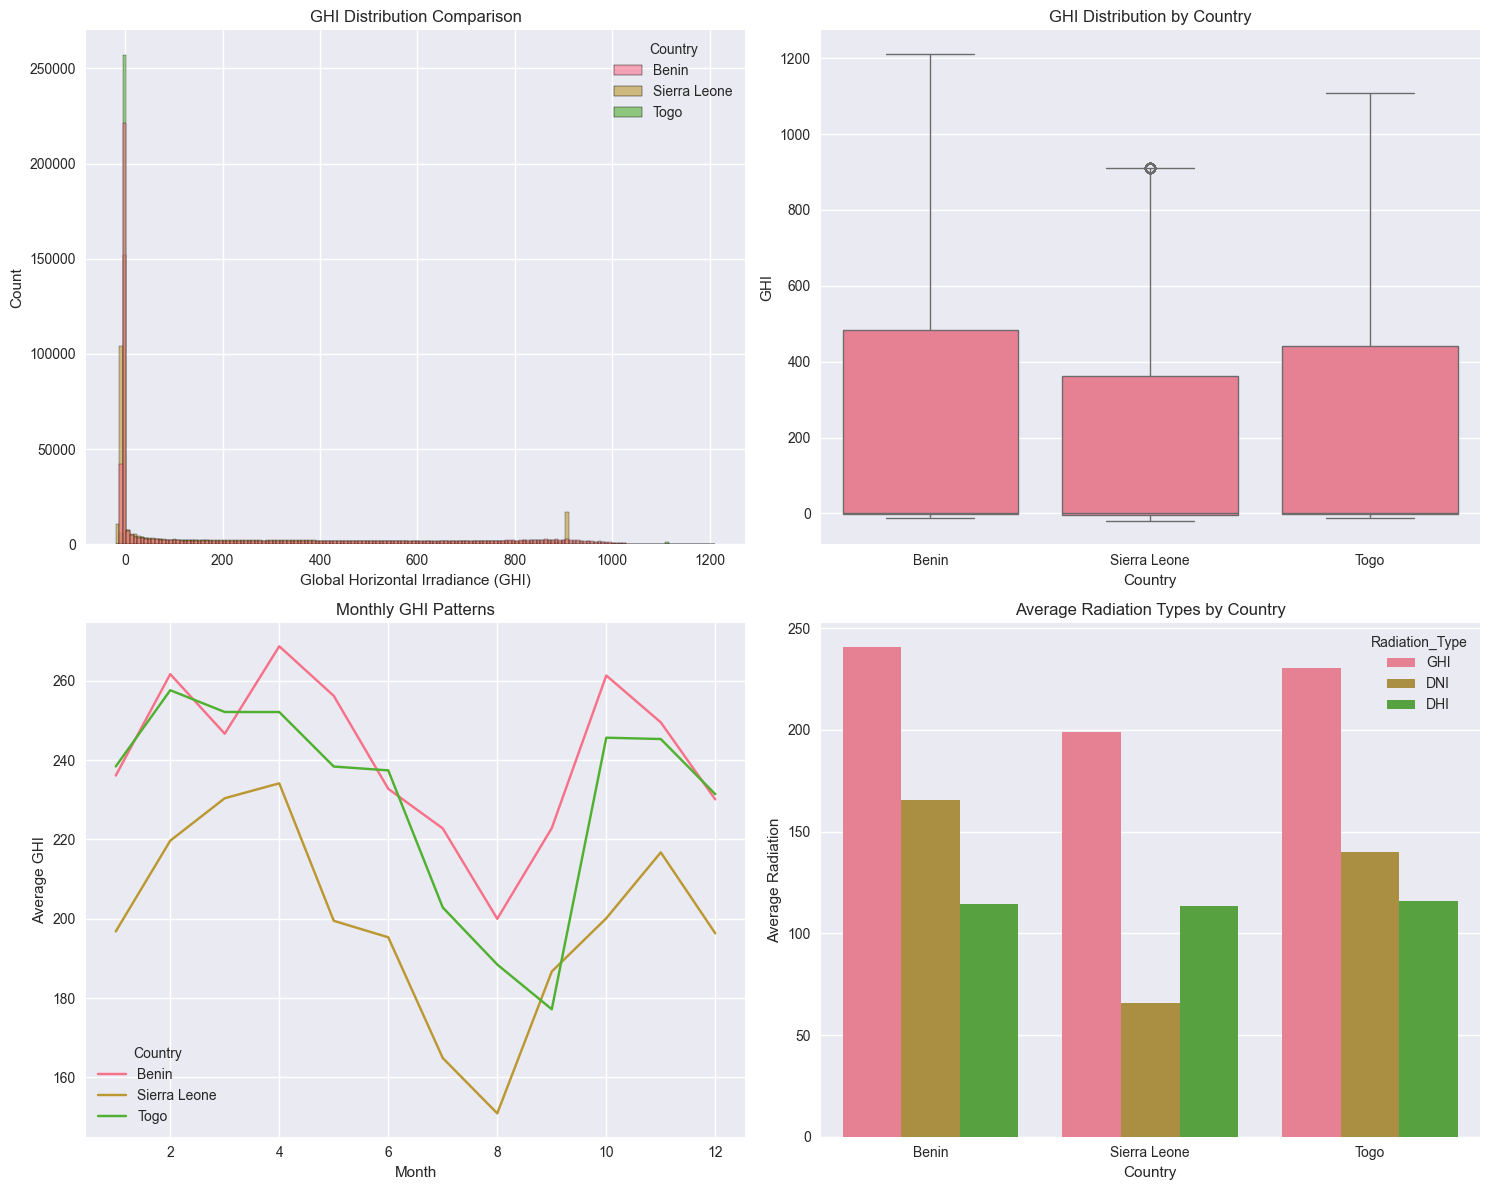

In [3]:
# %% [markdown]
# ## 2. Solar Radiation Pattern Comparison

# %%
def plot_radiation_comparison(benin, sierra_leone, togo):
    """Compare solar radiation patterns across countries"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # GHI Distribution Comparison
    radiation_data = []
    for country, data, color in [('Benin', benin, 'blue'), 
                                ('Sierra Leone', sierra_leone, 'green'),
                                ('Togo', togo, 'red')]:
        if 'GHI' in data.columns:
            radiation_data.extend([(country, ghi) for ghi in data['GHI'].dropna()])
    
    radiation_df = pd.DataFrame(radiation_data, columns=['Country', 'GHI'])
    
    # Distribution plot
    sns.histplot(data=radiation_df, x='GHI', hue='Country', ax=axes[0,0], alpha=0.6)
    axes[0,0].set_title('GHI Distribution Comparison')
    axes[0,0].set_xlabel('Global Horizontal Irradiance (GHI)')
    
    # Box plot
    sns.boxplot(data=radiation_df, x='Country', y='GHI', ax=axes[0,1])
    axes[0,1].set_title('GHI Distribution by Country')
    axes[0,1].set_ylabel('GHI')
    
    # Daily patterns (if timestamp available)
    # Monthly aggregation
    monthly_radiation = []
    for country, data in [('Benin', benin), ('Sierra Leone', sierra_leone), ('Togo', togo)]:
        if 'GHI' in data.columns and 'month' in data.columns:
            monthly_avg = data.groupby('month')['GHI'].mean().reset_index()
            monthly_avg['Country'] = country
            monthly_radiation.append(monthly_avg)
    
    if monthly_radiation:
        monthly_df = pd.concat(monthly_radiation)
        sns.lineplot(data=monthly_df, x='month', y='GHI', hue='Country', ax=axes[1,0])
        axes[1,0].set_title('Monthly GHI Patterns')
        axes[1,0].set_xlabel('Month')
        axes[1,0].set_ylabel('Average GHI')
    
    # Radiation type comparison
    radiation_types = []
    for country, data in [('Benin', benin), ('Sierra Leone', sierra_leone), ('Togo', togo)]:
        for rad_type in ['GHI', 'DNI', 'DHI']:
            if rad_type in data.columns:
                radiation_types.append({
                    'Country': country,
                    'Radiation_Type': rad_type,
                    'Value': data[rad_type].mean()
                })
    
    if radiation_types:
        rad_df = pd.DataFrame(radiation_types)
        sns.barplot(data=rad_df, x='Country', y='Value', hue='Radiation_Type', ax=axes[1,1])
        axes[1,1].set_title('Average Radiation Types by Country')
        axes[1,1].set_ylabel('Average Radiation')
    
    plt.tight_layout()
    plt.show()

plot_radiation_comparison(benin, sierra_leone, togo)

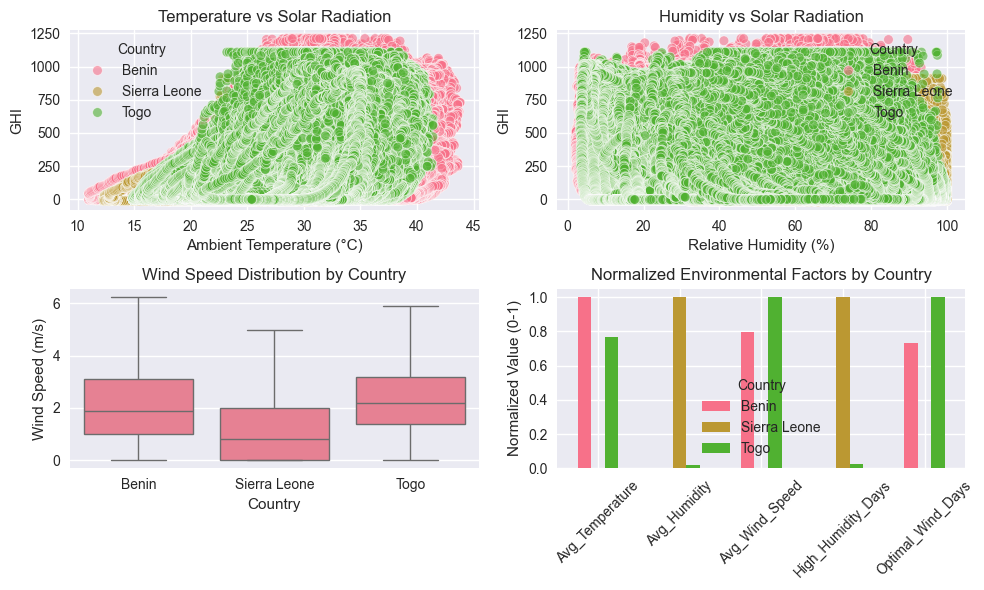

Environmental KPIs Summary:
              Avg_Temperature  Avg_Humidity  Avg_Wind_Speed  \
Country                                                       
Benin                  28.180        54.488           2.106   
Sierra Leone           26.319        79.449           1.138   
Togo                   27.752        55.013           2.351   

              High_Humidity_Days  Optimal_Wind_Days  
Country                                              
Benin                      0.250              0.468  
Sierra Leone               0.591              0.232  
Togo                       0.260              0.553  


In [4]:
# %% [markdown]
# ## 3. Environmental Factor Impact Analysis

# %%
def environmental_impact_analysis(all_countries):
    """Analyze how environmental factors affect solar potential"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Temperature vs GHI
    if all('Tamb' in df.columns and 'GHI' in df.columns for df in [benin, sierra_leone, togo]):
        sns.scatterplot(data=all_countries, x='Tamb', y='GHI', hue='Country', alpha=0.6, ax=axes[0,0])
        axes[0,0].set_title('Temperature vs Solar Radiation')
        axes[0,0].set_xlabel('Ambient Temperature (°C)')
        axes[0,0].set_ylabel('GHI')
    
    # Humidity vs GHI
    if all('RH' in df.columns and 'GHI' in df.columns for df in [benin, sierra_leone, togo]):
        sns.scatterplot(data=all_countries, x='RH', y='GHI', hue='Country', alpha=0.6, ax=axes[0,1])
        axes[0,1].set_title('Humidity vs Solar Radiation')
        axes[0,1].set_xlabel('Relative Humidity (%)')
        axes[0,1].set_ylabel('GHI')
    
    # Wind Speed impact
    if all('WS' in df.columns and 'GHI' in df.columns for df in [benin, sierra_leone, togo]):
        sns.boxplot(data=all_countries, x='Country', y='WS', ax=axes[1,0])
        axes[1,0].set_title('Wind Speed Distribution by Country')
        axes[1,0].set_ylabel('Wind Speed (m/s)')
    
    # Combined environmental factors
    environmental_kpis = kpis_df[['Country', 'Avg_Temperature', 'Avg_Humidity', 'Avg_Wind_Speed', 'High_Humidity_Days', 'Optimal_Wind_Days']]
    environmental_kpis.set_index('Country', inplace=True)
    
    # Normalize for radar chart preparation
    env_normalized = environmental_kpis.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    
    # Bar plot of normalized environmental factors
    env_normalized.T.plot(kind='bar', ax=axes[1,1], figsize=(10, 6))
    axes[1,1].set_title('Normalized Environmental Factors by Country')
    axes[1,1].set_ylabel('Normalized Value (0-1)')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return environmental_kpis

environmental_kpis = environmental_impact_analysis(all_countries)
print("Environmental KPIs Summary:")
print(environmental_kpis.round(3))

In [5]:
# %% [markdown]
# ## 4. Statistical Significance Testing

# %%
def statistical_testing(benin, sierra_leone, togo):
    """Perform statistical tests to validate differences between countries"""
    
    print("=" * 50)
    print("STATISTICAL SIGNIFICANCE TESTING")
    print("=" * 50)
    
    # Test for significant differences in GHI
    if all('GHI' in df.columns for df in [benin, sierra_leone, togo]):
        from scipy.stats import f_oneway, kruskal
        
        # ANOVA test for GHI means
        ghi_benin = benin['GHI'].dropna()
        ghi_sierra = sierra_leone['GHI'].dropna()
        ghi_togo = togo['GHI'].dropna()
        
        # One-way ANOVA
        f_stat, p_value = f_oneway(ghi_benin, ghi_sierra, ghi_togo)
        print(f"ANOVA Test for GHI differences:")
        print(f"F-statistic: {f_stat:.3f}, p-value: {p_value:.3f}")
        
        if p_value < 0.05:
            print("✅ Significant differences exist in GHI between countries")
        else:
            print("❌ No significant differences in GHI between countries")
        
        # Pairwise t-tests
        from scipy.stats import ttest_ind
        print("\nPairwise T-tests:")
        countries = [('Benin', ghi_benin), ('Sierra Leone', ghi_sierra), ('Togo', ghi_togo)]
        
        for i in range(len(countries)):
            for j in range(i+1, len(countries)):
                name1, data1 = countries[i]
                name2, data2 = countries[j]
                t_stat, p_val = ttest_ind(data1, data2, equal_var=False)
                significance = "✅ SIGNIFICANT" if p_val < 0.05 else "❌ Not significant"
                print(f"{name1} vs {name2}: t-stat={t_stat:.3f}, p-value={p_val:.3f} {significance}")

statistical_testing(benin, sierra_leone, togo)

STATISTICAL SIGNIFICANCE TESTING
ANOVA Test for GHI differences:
F-statistic: 2480.685, p-value: 0.000
✅ Significant differences exist in GHI between countries

Pairwise T-tests:
Benin vs Sierra Leone: t-stat=68.329, p-value=0.000 ✅ SIGNIFICANT
Benin vs Togo: t-stat=15.918, p-value=0.000 ✅ SIGNIFICANT
Sierra Leone vs Togo: t-stat=-52.438, p-value=0.000 ✅ SIGNIFICANT


In [9]:
# %% [markdown]
# ## 5. Region Ranking Algorithm

# %%
def calculate_ranking_scores(kpis_df):
    """Calculate composite scores and rank countries based on multiple factors"""
    
    # Define weights for different factors (adjust based on business priorities)
    weights = {
        'GHI_Mean': 0.25,           # Higher weight for primary solar metric
        'GHI_CV': -0.15,            # Negative weight - lower variation is better
        'DNI_Mean': 0.20,           # Direct radiation important for some technologies
        'High_Radiation_Days': 0.15,
        'Avg_Temperature': 0.05,    # Moderate weight - extreme temps can reduce efficiency
        'Avg_Humidity': -0.10,      # Negative - high humidity reduces efficiency
        'Optimal_Wind_Days': 0.08,
        'Data_Quality_Score': 0.12   # Reliability of analysis
    }
    
    print("Available columns in KPIs DataFrame:")
    print(kpis_df.columns.tolist())
    print("\nWeights being applied:")
    for col, weight in weights.items():
        exists = col in kpis_df.columns
        status = "✅" if exists else "❌"
        print(f"{status} {col}: {weight} ({'Available' if exists else 'Missing'})")
    
    # Use only available columns
    available_weights = {col: weight for col, weight in weights.items() if col in kpis_df.columns}
    print(f"\nUsing {len(available_weights)} available metrics out of {len(weights)}")
    
    # Normalize KPIs (0-1 scale)
    normalized_kpis = kpis_df.copy()
    
    for column, weight in available_weights.items():
        if column in normalized_kpis.columns:
            # Check if we have valid data (not all NaN)
            if normalized_kpis[column].notna().any():
                if weights[column] > 0:  # Higher is better
                    col_min = normalized_kpis[column].min()
                    col_max = normalized_kpis[column].max()
                    if col_max > col_min:  # Avoid division by zero
                        normalized_kpis[f'{column}_norm'] = (
                            (normalized_kpis[column] - col_min) / (col_max - col_min)
                        )
                    else:
                        normalized_kpis[f'{column}_norm'] = 0.5  # Neutral score if all same
                else:  # Lower is better (negative weight)
                    col_min = normalized_kpis[column].min()
                    col_max = normalized_kpis[column].max()
                    if col_max > col_min:
                        normalized_kpis[f'{column}_norm'] = (
                            (col_max - normalized_kpis[column]) / (col_max - col_min)
                        )
                    else:
                        normalized_kpis[f'{column}_norm'] = 0.5
            else:
                normalized_kpis[f'{column}_norm'] = 0.5  # Neutral if no data
    
    # Calculate weighted scores
    normalized_kpis['Composite_Score'] = 0
    
    for column, weight in available_weights.items():
        norm_column = f'{column}_norm'
        if norm_column in normalized_kpis.columns:
            normalized_kpis['Composite_Score'] += normalized_kpis[norm_column] * abs(weight)
    
    # Handle case where all scores are 0
    if normalized_kpis['Composite_Score'].sum() == 0:
        normalized_kpis['Composite_Score'] = 1.0  # Default equal score
    
    # Rank countries
    normalized_kpis['Rank'] = normalized_kpis['Composite_Score'].rank(ascending=False, method='dense')
    
    # Select output columns
    output_columns = ['Country', 'Composite_Score', 'Rank']
    norm_columns = [col for col in normalized_kpis.columns if '_norm' in col]
    
    ranked_countries = normalized_kpis[output_columns + norm_columns].sort_values('Rank')
    
    return ranked_countries, available_weights

# Calculate rankings
rankings, used_weights = calculate_ranking_scores(kpis_df)

print("\n" + "=" * 50)
print("COUNTRY RANKINGS FOR SOLAR INVESTMENT")
print("=" * 50)

for _, row in rankings.iterrows():
    print(f"Rank {int(row['Rank'])}: {row['Country']} (Score: {row['Composite_Score']:.3f})")

print(f"\nMetrics used in ranking ({len(used_weights)} total):")
for metric, weight in used_weights.items():
    print(f"  - {metric}: {weight}")

print("\nDetailed Ranking Analysis:")
print(rankings.round(3))

Available columns in KPIs DataFrame:
['Country', 'Total_Records', 'GHI_Mean', 'GHI_Std', 'GHI_Max', 'GHI_CV', 'High_Radiation_Days', 'DNI_Mean', 'DNI_Direct_Potential', 'Daily_Variation', 'Avg_Temperature', 'Avg_Humidity', 'High_Humidity_Days', 'Avg_Wind_Speed', 'Optimal_Wind_Days', 'Data_Quality_Score']

Weights being applied:
✅ GHI_Mean: 0.25 (Available)
✅ GHI_CV: -0.15 (Available)
✅ DNI_Mean: 0.2 (Available)
✅ High_Radiation_Days: 0.15 (Available)
✅ Avg_Temperature: 0.05 (Available)
✅ Avg_Humidity: -0.1 (Available)
✅ Optimal_Wind_Days: 0.08 (Available)
✅ Data_Quality_Score: 0.12 (Available)

Using 8 available metrics out of 8

COUNTRY RANKINGS FOR SOLAR INVESTMENT
Rank 1: Benin (Score: 0.869)
Rank 2: Togo (Score: 0.837)
Rank 3: Sierra Leone (Score: 0.210)

Metrics used in ranking (8 total):
  - GHI_Mean: 0.25
  - GHI_CV: -0.15
  - DNI_Mean: 0.2
  - High_Radiation_Days: 0.15
  - Avg_Temperature: 0.05
  - Avg_Humidity: -0.1
  - Optimal_Wind_Days: 0.08
  - Data_Quality_Score: 0.12

Det

In [11]:
# %% [markdown]
# ## 6. Investment Recommendations & Strategy

# %%
def generate_recommendations(rankings, kpis_df):
    """Generate data-driven investment recommendations"""
    
    print("=" * 50)
    print("INVESTMENT RECOMMENDATIONS")
    print("=" * 50)
    
    top_country = rankings.iloc[0]['Country']
    top_score = rankings.iloc[0]['Composite_Score']
    
    print(f"🏆 TOP RECOMMENDATION: {top_country}")
    print(f"   Composite Score: {top_score:.3f}")
    
    # Strengths analysis
    top_country_data = kpis_df[kpis_df['Country'] == top_country].iloc[0]
    
    print("\n📊 KEY STRENGTHS:")
    if top_country_data['GHI_Mean'] == kpis_df['GHI_Mean'].max():
        print("   ✓ Highest average solar radiation (GHI)")
    if top_country_data['GHI_CV'] == kpis_df['GHI_CV'].min():
        print("   ✓ Most consistent solar radiation patterns")
    if 'High_Radiation_Days' in top_country_data and top_country_data['High_Radiation_Days'] == kpis_df['High_Radiation_Days'].max():
        print("   ✓ Highest frequency of high-radiation days")
    
    # Technology-specific recommendations
    print("\n🔧 TECHNOLOGY RECOMMENDATIONS:")
    if top_country_data['DNI_Mean'] > top_country_data['GHI_Mean'] * 0.6:
        print("   ✓ Suitable for concentrated solar power (CSP) - High DNI")
    else:
        print("   ✓ Optimal for photovoltaic (PV) systems - Good GHI")
    
    # Risk factors
    print("\n⚠️  CONSIDERATIONS:")
    if top_country_data['Avg_Humidity'] > 70:
        print("   • High humidity may require more frequent panel maintenance")
    if top_country_data['High_Humidity_Days'] > 0.3:
        print("   • Significant humid days could impact efficiency")
    
    # Runner-up analysis
    if len(rankings) > 1:
        second_country = rankings.iloc[1]['Country']
        print(f"\n🥈 STRONG CONTENDER: {second_country}")
        print(f"   Consider for diversified investment portfolio")
    
    return top_country

top_recommendation = generate_recommendations(rankings, kpis_df)

INVESTMENT RECOMMENDATIONS
🏆 TOP RECOMMENDATION: Benin
   Composite Score: 0.869

📊 KEY STRENGTHS:
   ✓ Highest average solar radiation (GHI)
   ✓ Most consistent solar radiation patterns

🔧 TECHNOLOGY RECOMMENDATIONS:
   ✓ Suitable for concentrated solar power (CSP) - High DNI

⚠️  CONSIDERATIONS:

🥈 STRONG CONTENDER: Togo
   Consider for diversified investment portfolio


In [12]:
# %% [markdown]
# ## 7. Results Export

# %%
def export_comparison_results(rankings, kpis_df, all_countries):
    """Export comparison results for reporting"""
    
    import os
    
    # Create results directory
    os.makedirs('../results', exist_ok=True)
    
    # Export rankings
    rankings.to_csv('../results/country_rankings.csv', index=False)
    print("✅ Country rankings exported to results/country_rankings.csv")
    
    # Export detailed KPIs
    kpis_df.to_csv('../results/detailed_kpis.csv', index=False)
    print("✅ Detailed KPIs exported to results/detailed_kpis.csv")
    
    # Export summary statistics
    summary_stats = all_countries.groupby('Country').agg({
        'GHI': ['mean', 'std', 'min', 'max'],
        'Tamb': ['mean', 'std'],
        'RH': ['mean', 'std'],
        'WS': ['mean', 'std']
    }).round(3)
    
    summary_stats.to_csv('../results/summary_statistics.csv')
    print("✅ Summary statistics exported to results/summary_statistics.csv")
    
    print("\n📁 All results exported to 'results/' directory")
    print("   Note: Add 'results/' to .gitignore if containing sensitive analysis")

export_comparison_results(rankings, kpis_df, all_countries)

✅ Country rankings exported to results/country_rankings.csv
✅ Detailed KPIs exported to results/detailed_kpis.csv
✅ Summary statistics exported to results/summary_statistics.csv

📁 All results exported to 'results/' directory
   Note: Add 'results/' to .gitignore if containing sensitive analysis
